In [368]:
import torchhd
import torch
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import math
from functools import partial
import scipy.stats as stats

In [369]:
import sys
sys.path.append('..')
from shared_code.helpers import similarity_func_partial

In [370]:
VSA_TYPE = 'BSC'
DIMENSIONS = [2**i for i in range(9, 14, 2)]
BUNDLE_SIZES = list(range(2, 200, 2))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if device == 'cuda':
    torch.cuda.empty_cache()

batches = 10
item_memory_size = 10_000
MAX_BUNDLE_SIZE = BUNDLE_SIZES[-1]

In [371]:
sim_tensors = torch.zeros(len(DIMENSIONS), item_memory_size) # Store similarities between randomly generated vector and item memory (also randomly generated by definition)

similarity_func = partial(similarity_func_partial, VSA_TYPE)


for dim_idx in tqdm(range(len(DIMENSIONS))):
  dim = DIMENSIONS[dim_idx]

  item_memory = torchhd.random(item_memory_size, dim, vsa=VSA_TYPE, device=device)

  reference_vector = torchhd.random(1, dim, vsa=VSA_TYPE, device=device)

  similarities = similarity_func(reference_vector, item_memory)

  sim_tensors[dim_idx, :] = similarities

100%|██████████| 3/3 [00:00<00:00, 21.93it/s]


### Historgam of similarities for each vsa type

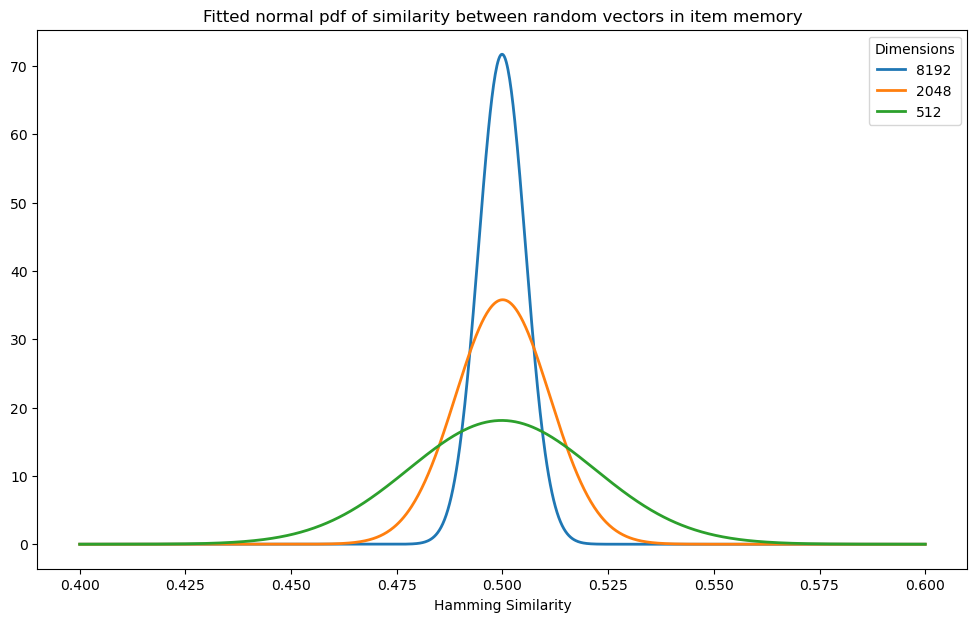

In [372]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

bin_scale_factor = 70

data = sim_tensors[:, :].cpu().numpy()
dimensions = DIMENSIONS[:]

fig, ax = plt.subplots()

for idx, dim in reversed(list(enumerate(dimensions))):
  data_dim = data[idx, :]
  # fit a normal distribution to the data
  mu, std = stats.norm.fit(data_dim)
  # plot the fitted distribution
  xmin, xmax = .4, .6
  samples = 1000
  x = np.linspace(xmin, xmax, samples)
  p = stats.norm.pdf(x, mu, std)
  c = stats.norm.pdf(0.5, mu, std)
  ax.plot(x, p, linewidth=2, label=f'{dim}')

  # ax.hist(data[idx, :], bins=int(bin_scale_factor), range=(0.4, 0.6), density=True, alpha=0.75, label=f'{dim}')

# for idx, dim in reversed(list(enumerate(dimensions))):
#     ax.plot(sorted(data[idx, :]), stats.norm.pdf(sorted(data[idx, :]), np.mean(data[idx, :]), np.std(data[idx, :])), label=f'{dim}')
#     ax.scatter(data[idx, :], stats.norm.pdf(data[idx, :], np.mean(data[idx, :]), np.std(data[idx, :])), label=f'{dim}', color=idx, marker='o')

ax.set_xlabel('Hamming Similarity')
# ax.set_ylabel('Number of items')
ax.set_title('Fitted normal pdf of similarity between random vectors in item memory')
ax.legend(title='Dimensions', loc='upper right')
# ax.grid(True)
fig.set_size_inches(12, 7)
plt.show()

In [375]:
# bin_scale_factor = 512
# num_bins = 50

# data = sim_tensors[:, :].cpu().numpy()
# dimensions = DIMENSIONS[:]

# fig, ax = plt.subplots()

# bins = np.linspace(0.4, 0.6, num_bins)

# for idx, dim in reversed(list(enumerate(dimensions))):
#   data_dim = data[idx, :]
#   results, edges = np.histogram(data_dim, bins=bins)
#   bin_width = edges[1] - edges[0]
#   weights = results / float(results.sum())
#   ax.hist(edges[:-1], edges, weights=weights, alpha=0.75, label=f'{dim}')

# ax.set_xlabel('Hamming Similarity')
# ax.set_ylabel('# of items in bin / Total items in memory')
# ax.set_title('Distribution of similarity between random vectors in item memory')
# ax.legend(title='Dimensionality (D)', loc='upper right')
# fig.set_size_inches(12, 7)
# plt.show()

bin_scale_factor = 512

data = sim_tensors[:, :].cpu().numpy()
dimensions = DIMENSIONS[:]

fig = go.Figure()

for idx, dim in reversed(list(enumerate(dimensions))):
  fig.add_trace(go.Histogram(x=data[idx, :], name=f'{dim}', xbins=dict(size=1/bin_scale_factor, start=0.4, end=0.6), autobinx=False, opacity=.75, histnorm='probability', marker=dict(color=idx)))

# for idx, dim in reversed(list(enumerate(dimensions))):
# for idx, dim in enumerate(dimensions):
#   fig.add_trace(go.Line(x=sorted(data[idx, :]), y=stats.norm.pdf(sorted(data[idx, :]), np.mean(data[idx, :]), np.std(data[idx, :])), name=f'{dim}'))
#   fig.add_trace(go.Scatter(x=data[idx, :], y=stats.norm.pdf(data[idx, :], np.mean(data[idx, :]), np.std(data[idx, :])), name=f'{dim}', mode='markers', marker=dict(color=idx)), pro

fig.update_layout(
  xaxis_title='Hamming Similarity',
  yaxis_title='# of items in bin / Total items in memory',
  title=dict(
    text=f'Distribution of similarity between random vectors in item memory',
    x=0.5,
    y=.965,
  ),
  legend=dict(
    orientation="h",
    yanchor="top",
    y=1.075,
    xanchor="center",
    x=0.5,
    title='Dimensionality (D)'
  ),
  font=dict(
    size=18,
  ),
  # bargap=0.1,
  barmode='overlay',
  width=1250,
  height=750,
  margin=dict(l=120, r=100, t=100, b=80),
)
fig.show()


In [374]:
# Plotting mean and std of similarity for each vsa type

fig, ax = plt.subplots(nrows=(len(VSA_TYPES)+1)//2, ncols=2, figsize=(15, 5 * ((len(VSA_TYPES)+1)//2)))
fig.suptitle(f'Mean and std of similarity, {item_memory_size} items in memory')

for vsa_type_idx in range(len(VSA_TYPES)):
    vsa_type = VSA_TYPES[vsa_type_idx]
    row = (vsa_type_idx+1) // 2 - 1
    col = vsa_type_idx % 2
    mean_similarities = torch.mean(sim_tensors[vsa_type_idx, :, :], dim=1)
    #subtract 0.5 from mean if vsa type is BSC to ensure correct scale
    if vsa_type == 'BSC':
      mean_similarities -= 0.5
    std_similarities = torch.std(sim_tensors[vsa_type_idx, :, :], dim=1)
    ax[row, col].plot(DIMENSIONS, mean_similarities.cpu().numpy(), label='mean')
    ax[row, col].plot(DIMENSIONS, std_similarities.cpu().numpy(), label='std')
    ax[row, col].set_title(vsa_type)
    ax[row, col].set_xlabel('Dimension')
    ax[row, col].set_ylabel('Similarity')
    ax[row, col].legend()

NameError: name 'VSA_TYPES' is not defined

Why does the normalization have such a big effect on the similarity for BSC and MAP HDVectors?
Normalization intoduces noice, especially for BSC and MAP HDVectors, which have only 2 possible values for each dimension. For MAP I believe a solid workaround is to use MAP-I instead of MAP-B, which is actually the default for torchhd.

In [ ]:
vsa_type = 'MAP'


def seq_bundling(vecs):
    bundle_vec = vecs[0]
    for vec in vecs[1:]:
        bundle_vec = bundle_vec.bundle(vec)
        if type(vecs[0]) == torchhd.MAPTensor:
            bundle_vec = bundle_vec.clipping(1)
    return bundle_vec


dim = 10
amount_of_items = 5

identity_vecs = torchhd.identity(amount_of_items, dim, vsa=vsa_type) #identity for bind operation (all ones)
random_vecs = torchhd.random(amount_of_items, dim, vsa=vsa_type)

experiment_vecs = torch.vstack([identity_vecs, random_vecs])

_bundle = seq_bundling(experiment_vecs)
print(_bundle)
_multiset = torchhd.multiset(experiment_vecs)
if vsa_type == 'MAP':
    _multiset = _multiset.clipping(1)
print(_multiset)


dim = 500
amount_of_items = 10

identity_vecs = torchhd.identity(amount_of_items, dim, vsa=vsa_type) #identity for bind operation (all ones)
random_vecs = torchhd.random(amount_of_items, dim, vsa=vsa_type)

experiment_vecs = torch.vstack([identity_vecs, random_vecs])

_bundle = seq_bundling(experiment_vecs)
_multiset = torchhd.multiset(experiment_vecs)
if vsa_type == 'MAP':
    _multiset = _multiset.clipping(1)

sim_func = partial(similarity_func_partial, vsa_type)

_bundle_similarities = [sim_func(k, _bundle) for k in experiment_vecs]
_multiset_similarities = [sim_func(k, _multiset) for k in experiment_vecs]


# effect is exaggerated here by first bundling all identity vectors and then bundling the random vectors
# leading to the fact that the similarity to identity vectors is near 0 when we bundle sequentially
print(f'average similarity of sequential bundling: {torch.mean(torch.stack(_bundle_similarities))}')
print(f'average similarity of multiset: {torch.mean(torch.stack(_multiset_similarities))}')

MAPTensor([ 0., -1.,  1.,  0., -1., -1.,  1.,  0.,  1.,  0.])
MAPTensor([1., 1., 1., 1., 1., 0., 1., 1., 1., 1.])
average similarity of sequential bundling: MAPTensor(0.1128)
average similarity of multiset: MAPTensor(0.5110)


### Looking at normalisation of HRR vectors

In [ ]:
import torch.nn.functional as F
dim = 1000
exp_size = 1000

v = torchhd.random(exp_size, dim, vsa='HRR')

first = v[0]
print(f"euclidean norm of first vector: {torch.norm(first)}")
first = torchhd.random(1, dim, vsa='HRR')
seq_bundle_vec = torchhd.empty(1, dim, vsa='HRR')
print(f"cosine similarity of random vector and first vector: {torchhd.cosine_similarity(seq_bundle_vec, first)}")


for i in range(1, exp_size):
    seq_bundle_vec = seq_bundle_vec.bundle(v[i])
    seq_bundle_vec = F.normalize(seq_bundle_vec, p=2, dim=-1)

print(f"euclidean norm of sequential bundle vector: {torch.norm(seq_bundle_vec)}")
print(f"cosine similarity of sequential bundle vector and first vector: {torchhd.cosine_similarity(seq_bundle_vec, first)}")
    

euclidean norm of first vector: HRRTensor(0.9955)
cosine similarity of random vector and first vector: HRRTensor([[0.]])
euclidean norm of sequential bundle vector: HRRTensor(1.)
cosine similarity of sequential bundle vector and first vector: HRRTensor([[0.0119]])


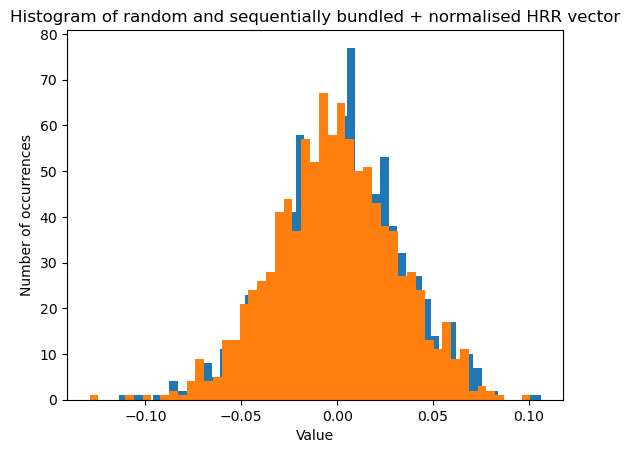

In [ ]:
# histogram of single hrr vector
import matplotlib.pyplot as plt

plt.hist(first[0].cpu().numpy(), bins=50)
plt.hist(seq_bundle_vec[0].cpu().numpy(), bins=50)
plt.title('Histogram of random and sequentially bundled + normalised HRR vector')
plt.xlabel('Value')
plt.ylabel('Number of occurrences')
plt.show()

Experiment of ngram or hist statistics using sequential but non normalized bundles.

In [ ]:
from ..helpers import similarity_func_partial
from functools import partial

dim = 10_000
vocab_size = 600
exp_size = 200
# vocab_size = 33_000
# exp_size = 1500
vsa_type = 'MAP'
sim_func = partial(similarity_func_partial, vsa_type)

vocab = torchhd.random(vocab_size, dim, vsa=vsa_type, device=device)
random_indices = torch.randperm(vocab_size)[:exp_size]

bundled_vec = torchhd.empty(1, dim, vsa=vsa_type, device=device)

for iteration, bundle_vec_idx in enumerate(random_indices):
    bundled_vec = bundled_vec.bundle(vocab[bundle_vec_idx])
    # for i in range(iteration):
        # bundled_vec = bundled_vec.bundle(vocab[bundle_vec_idx])
    if iteration % 100 == 0:
        print(f'iteration {iteration}')

bundled_vec_similarities = sim_func(bundled_vec, vocab[random_indices])[0].cpu().numpy()
similarities = sim_func(bundled_vec, vocab)[0].cpu().numpy()

iteration 0
iteration 100


<BarContainer object of 200 artists>

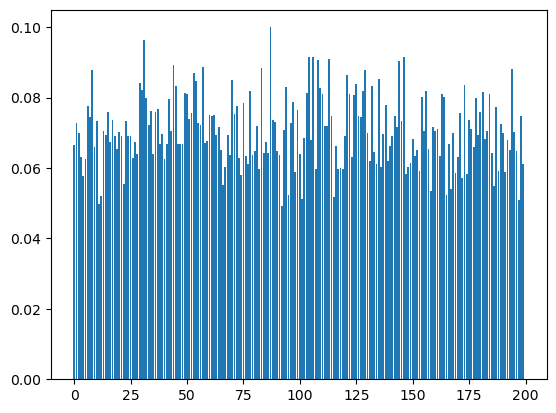

In [ ]:
plt.bar(range(len(bundled_vec_similarities)), bundled_vec_similarities)

<BarContainer object of 600 artists>

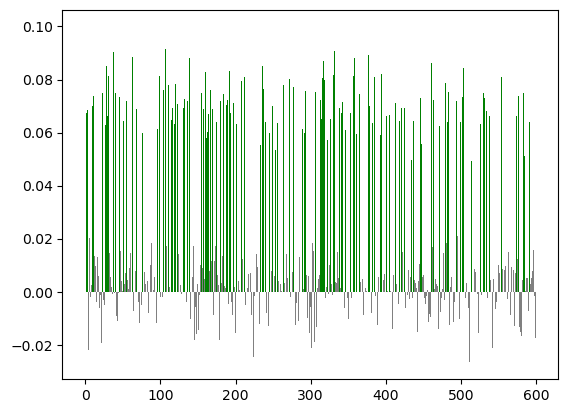

In [ ]:
colors = ['green' if i in random_indices else 'gray' for i in range(len(similarities))]
plt.bar(range(len(similarities)), similarities, color=colors)